In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
from pyparsing import python_style_comment
from itertools import islice

# More Power Ratio
Values matched for BPPM photon number and PPM time bin
<br>5,5 
<br>6,8 
<br>7,11 
<br>8,14 (exact)
<br>9,18 
<br>10,24 (exact)
<br>11,30 (exact)
<br>12,38 (exact)
<br>13,47 (exact)

# BPPM

In [2]:
from functools import lru_cache

comb_cache = {}
#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
# def combination(n, r):
#     # if r > n:
#     #     return 0
#     # else:
#     return math.factorial((int(n))) / (math.factorial((int(n-r))) * math.factorial((int(r))))


def combination(n, r):
    if (n, r) in comb_cache:
        return comb_cache[(n, r)]
    else:
        comb = math.factorial(n) // (math.factorial(n-r) * math.factorial(r))
        comb_cache[(n, r)] = comb
        return comb
    
@lru_cache(maxsize=None)
def compute_N(n):
  def agen(): # generator of terms
      aset, sset, k = set(), set(), 0
      while True:
          k += 1
          while any(k+an in sset for an in aset): k += 1
          yield k; sset.update(k+an for an in aset); aset.add(k)
  a = list(islice(agen(), 100))
  photon = list(map(lambda v: v-1, a))
  compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
  return compute_N[n]



# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution
comb_n_cache = {}

# def Loss_Distribute(n, P_l, l):
    # # if P_l == 0:
    # #     return 1
    # # else:
    #   return combination(n, l) * (P_l)**l * (1 - P_l)**(n - l)

def Loss_Distribute(n, P_l, l):
    if (n, l) in comb_n_cache:
        comb_n = comb_n_cache[(n, l)]
    else:
        comb_n = combination(n, l)
        comb_n_cache[(n, l)] = comb_n

    return comb_n * (P_l)**l * (1 - P_l)**(n - l)

# def Add_Distribute(n, P_a, a):
#     N_n = compute_N(n)
#     # if P_a == 0:
#     #     return 1
#     # else:
#     return combination(N_n - n, a) * (P_a)**a * (1 - P_a)**(N_n - n - a)

comb_n_M_minus_n_cache = {}
def Add_Distribute(n, P_a, a):
    N_n = compute_N(n)
    M_minus_n = compute_N(n) - N_n
    if (N_n, M_minus_n, a) in comb_n_M_minus_n_cache:
        comb_Nn_Mn = comb_n_M_minus_n_cache[(N_n, M_minus_n, a)]
    else:
        comb_Nn_Mn = combination(N_n + M_minus_n, a)
        comb_n_M_minus_n_cache[(N_n, M_minus_n, a)] = comb_Nn_Mn

    return comb_Nn_Mn * (P_a)**a * (1 - P_a)**(M_minus_n - a)

# define a separate function for computing the probability of error
def P_err(n, P_l, P_a,l,a):
  return Loss_Distribute(n,P_l,l) * Add_Distribute(n,P_a, a)
  #return combination(n,l) * (P_l)**l*(1-P_l)**(n-l) * combination(N-n,a) * (P_a)**a*(1-P_a)**(N-n-a) 

# We put these into P_D for re-normalization, These are the probability of error we can correct
# define separate functions for computing the probability of success
def P_Success0(n,P_l,P_a,l,a):
  return P_err(n,P_l, P_a,0,0)

def P_Success1(n,P_l,P_a,l,a):
  P0 = P_Success0(n, P_l, P_a,l,a)
  P1 = P_err(n, P_l, P_a, l=0, a=1) + P_err(n, P_l, P_a, l=1, a=0)
  return P0 + P1

def P_Success2(n,P_l,P_a,l,a):
  P1 = P_Success1(n, P_l, P_a)
  P2 = P_err(n, P_l, P_a, l=1, a=1) + P_err(n, P_l, P_a, l=2, a=0) + P_err(n, P_l, P_a, l=0, a=2)
  return P1 + P2

def P_Success3(n,P_l,P_a,l,a):
  P2 = P_err(n, P_l, P_a, l=1, a=1) + P_err(n, P_l, P_a, l=2, a=0) + P_err(n, P_l, P_a, l=0, a=2)
  P3 = P_err(n, P_l, P_a,1,2) + P_err(n, P_l, P_a, 2,1) + P_err(n, P_l, P_a,3,0) + P_err(n, P_l, P_a,0,3)
  return P2 + P3

def P_D(n,P_l,P_a,l,a):
  
# we only consider at most 1 error, i.e. P_0 + P_1
  return 1 - P_Success1(n,P_l,P_a,l,a)

def P_AB_BPPM(n, P, P_D):
    matrix = (1/math.factorial(n)) * (1-P_D) * np.eye(math.factorial(n))
    return matrix


# sum over the elements in rows in the probability matrix P_AB
# renormalized in P_AB already
def P_A_BPPM(P_AB_BPPM, P_D):
    if P_D == 1:
        return [1 for row in P_AB_BPPM]
    else:
        return [1/(1-P_D) * sum(row) for row in P_AB_BPPM] 
# sum over the elements in columns in the probability matrix P_AB
# renormalized in P_AB already
def P_B_BPPM(P_AB_BPPM, P_D):
    if P_D == 1:
        return [1 for col in zip(*P_AB_BPPM)]
    else:
        return [1/(1-P_D) * sum(col) for col in zip(*P_AB_BPPM)]
# # calculate the trace of the probability matrix P_AB
# def trace_P_AB(P_AB):
#     return sum([P_AB[i][i] for i in range(len(P_AB))])

# H_A, H_B, H_AB are the same as the trivial case
def H_A_BPPM(P_AB_BPPM):
     P_A_BPPM = np.sum(P_AB_BPPM, axis=1)
     H_a = np.sum(-P_A_BPPM * np.log2(np.where(P_A_BPPM == 0, 1, P_A_BPPM)))
     return H_a

def H_B_BPPM(P_AB_BPPM):
     P_B_BPPM = np.sum(P_AB_BPPM, axis=0)

     H_b = np.sum(-P_B_BPPM * np.log2(np.where(P_B_BPPM == 0, 1, P_B_BPPM)))
     return H_b

def H_AB_BPPM(P_AB_BPPM):
    P_AB_BPPM = np.where(P_AB_BPPM == 0, 1e-9, P_AB_BPPM)  # replace zero values with 1e-9
    H = -(P_AB_BPPM * np.log2(P_AB_BPPM)).sum()
    return H

# def I_AB(H_A, H_B, H_AB, P_D):
#   return ((H_A + H_B - H_AB))*(1-P_D)

def I_AB_BPPM(H_A_BPPM, H_B_BPPM, H_AB_BPPM, P_D):
    if np.isnan(H_AB_BPPM):
        return 0
    else:
        return ((H_A_BPPM + H_B_BPPM - H_AB_BPPM))*(1-P_D)


# PPM

M_minus_n_PPM is used to represent the number of elements that are not in the set of n_PPM elements. In the context of this code, M_minus_n_PPM is used to compute the number of elements in the "add" set, which is the set of elements not in the "loss" set.

By subtracting n_PPM from M, we get the number of elements not in the "loss" set. Then, we can use this value along with the number of elements in the "add" set to compute the probabilities of error and success.


In [3]:
# import math
# from functools import lru_cache
# import numpy as np

# def compute_M(M):
#   return M

# #we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# # define a separate function for computing the sequence of terms used in N

# @lru_cache(maxsize=None)
# def combination_PPM(n_PPM, r):
#     return math.factorial(int(n_PPM)) // (math.factorial((n_PPM-r)) * math.factorial((r)))

# # We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# # define a separate function for computing the loss distribution

# @lru_cache(maxsize=None)
# def Loss_Distribute_PPM(n_PPM, P_l, l):
#       return combination(n_PPM, l) * (P_l**l) * ((1 - P_l)**(n_PPM - l))

# @lru_cache(maxsize=None)
# def Add_Distribute_PPM(n_PPM, M_minus_n_PPM, P_a, a):
#     return combination(M_minus_n_PPM, a) * (P_a**a) * (1 - P_a)**((M_minus_n_PPM - a))

# # define a separate function for computing the probability of error
# @lru_cache(maxsize=None)
# def P_err(n_PPM, M_minus_n_PPM, P_l, P_a,l,a):
#   return Loss_Distribute(n_PPM,P_l,l) * Add_Distribute(n_PPM,M_minus_n_PPM, P_a, a)
#   #return combination(n,l) * (P_l)**l*(1-P_l)**(n-l) * combination(N-n,a) * (P_a)**a*(1-P_a)**(N-n-a) 

# def P_Success_PPM(n_PPM,M_minus_n_PPM, P_l,P_a):
#   return P_err(n_PPM, M_minus_n_PPM, P_l, P_a, l=0, a=0) 

# # Perr[l = 0, a = 0, n = 1, N = M, Ploss, Padd] from mathematica

# def P_D_PPM(n_PPM, M_minus_n_PPM, P_l,P_a, l=0,a=0):
#   return 1 - P_Success_PPM(n_PPM, M_minus_n_PPM, P_l,P_a, l=0, a=0)

# def P_AB_PPM(n, M_minus_n_PPM, P_D_PPM):
#     matrix =  np.eye(2*M_minus_n_PPM) * 1/(2* M_minus_n_PPM)  #[[1/M * P_AB_PPM[i] if i == j else 0 for j in range(M)] for i in range(M)]
#     return matrix 

# # sum over the elements in rows in the probability matrix P_AB
# def P_A_PPM(P_AB_PPM, P_D_PPM):
#     if P_D == 1:
#         return np.ones(P_AB_PPM.shape[0])
#     else:
#         return np.sum(P_AB_PPM, axis=1) # 1/(1-P_D_PPM)*

# # sum over the elements in columns in the probability matrix P_AB
# def P_B_PPM(P_AB_PPM, P_D_PPM):
#     if P_D == 1:
#         return np.ones(P_AB_PPM.shape[1])
#     else:
#         return np.sum(P_AB_PPM, axis=0)
    
# def H_A_PPM(P_AB_PPM):
#      P_A_PPM = np.sum(P_AB_PPM, axis=1)
#      H_a_PPM = np.sum(-P_A_PPM * np.log2(np.where(P_A_PPM == 0, 1, P_A_PPM)))
#      return H_a_PPM

# def H_B_PPM(P_AB_PPM):
#      P_B_PPM = np.sum(P_AB_PPM, axis=0)
#      H_b_PPM = np.sum(-P_B_PPM * np.log2(np.where(P_B_PPM == 0, 1, P_B_PPM)))
#      return H_b_PPM

# def H_AB_PPM(P_AB_PPM):
#     P_AB_PPM = np.where(P_AB_PPM == 0, 1e-9, P_AB_PPM)  # replace zero values with 1e-9
#     H_PPM = -(P_AB_PPM * np.log2(P_AB_PPM)).sum()
#     return H_PPM

# def I_AB_PPM(H_A_PPM, H_B_PPM, H_AB_PPM, P_D_PPM):
#     # if np.isnan(H_AB_PPM):
#     #     return 0
#     # else:
#         return ((H_A_PPM + H_B_PPM - H_AB_PPM)) * (1-P_D_PPM)


In [4]:
def compute_M(M):
  return M

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination_PPM(n_PPM, r):
    # if r > n:
    #     return 0
    # else:
    return math.factorial((int(n_PPM))) / (math.factorial((int(n_PPM-r))) * math.factorial((int(r))))

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_PPM(n_PPM, P_l, l):
    # if P_l == 0:
    #     return 1
    # else:
      return combination(n_PPM, l) * (P_l)**l * (1 - P_l)**(n_PPM - l)

def Add_Distribute_PPM(n_PPM, P_a, a):
    #M = compute_M(M)
    # if P_a == 0:
    #     return 1
    # else:
    return combination(M - n_PPM, a) * (P_a)**a * (1 - P_a)**(M - n_PPM - a)

# define a separate function for computing the probability of error
def P_err(n_PPM, P_l, P_a,l,a):
  return Loss_Distribute(n_PPM,P_l,l) * Add_Distribute(n_PPM,P_a, a)
  #return combination(n,l) * (P_l)**l*(1-P_l)**(n-l) * combination(N-n,a) * (P_a)**a*(1-P_a)**(N-n-a) 

def P_Success_PPM(n_PPM,P_l,P_a,l,a):
  return P_err(n_PPM,P_l, P_a, l=0, a=0) 

# Perr[l = 0, a = 0, n = 1, N = M, Ploss, Padd] from mathematica

def P_D_PPM(_PPM,P_l,P_a, l=0,a=0):
  return 1 - P_Success_PPM(n_PPM,P_l,P_a, l=0, a=0)


def P_AB_PPM(n, P_D_PPM):
    #M = compute_M(M) #int(len(list(itertools.permutations(range(n)))))
    # P_AB_PPM = [(P ** i) * ((1 - P) ** (n - 1 - i)) for i in range(n)]
    # P_AB_PPM = [(1-P_D_PPM) for i in range(M)]
    matrix =  np.eye(2*M) * 1/(2*M)  #[[1/M * P_AB_PPM[i] if i == j else 0 for j in range(M)] for i in range(M)]
    return matrix 

# sum over the elements in rows in the probability matrix P_AB
def P_A_PPM(P_AB_PPM, P_D_PPM):
    if P_D == 1:
        return [1 for row in P_AB_PPM]
    else:
        return [sum(row) for row in P_AB_PPM] # 1/(1-P_D_PPM)*

# sum over the elements in columns in the probability matrix P_AB
def P_B_PPM(P_AB_PPM, P_D_PPM):
    if P_D == 1:
        return [1 for col in zip(*P_AB_PPM)]
    else:
        return [sum(col) for col in zip(*P_AB_PPM)]
def H_A_PPM(P_AB_PPM):
     P_A_PPM = np.sum(P_AB_PPM, axis=1)
     H_a_PPM = np.sum(-P_A_PPM * np.log2(np.where(P_A_PPM == 0, 1, P_A_PPM)))
     return H_a_PPM

def H_B_PPM(P_AB_PPM):
     P_B_PPM = np.sum(P_AB_PPM, axis=0)
     H_b_PPM = np.sum(-P_B_PPM * np.log2(np.where(P_B_PPM == 0, 1, P_B_PPM)))
     return H_b_PPM

def H_AB_PPM(P_AB_PPM):
    P_AB_PPM = np.where(P_AB_PPM == 0, 1e-9, P_AB_PPM)  # replace zero values with 1e-9
    H_PPM = -(P_AB_PPM * np.log2(P_AB_PPM)).sum()
    return H_PPM

def I_AB_PPM(H_A_PPM, H_B_PPM, H_AB_PPM, P_D_PPM):
    if np.isnan(H_AB_PPM):
        return 0
    else:
        return ((H_A_PPM + H_B_PPM - H_AB_PPM)) * (1-P_D_PPM)


# General

In [5]:
def compute_T_General(n_General, M):
  T_General = compute_M(M) * n_General # int(len(list(itertools.permutations(range(n)))))
  
  return T_General

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination_General(T_General, n_General):
    # if r > n:
    #     return 0
    # else:
    # return math.factorial((int(T_General))) / (math.factorial((int(T_General-n_General))) * math.factorial((int(n_General))))
    return math.factorial(((T_General))) / (math.factorial(((T_General-n_General))) * math.factorial(((n_General))))

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_General(n_General, P_l, l):
    # if P_l == 0:
    #     return 1
    # else:
      return combination(n_General, l) * (P_l)**l * (1 - P_l)**(n_General - l)

def Add_Distribute_General(n_General, P_a, a):
    T_General = compute_T_General(n_General)
    # if P_a == 0:
    #     return 1
    # else:
    return combination(T_General - n, a) * (P_a)**a * (1 - P_a)**(T_General - n_General - a)

# define a separate function for computing the probability of error
def P_err(n_General, P_l, P_a,l,a):
  return Loss_Distribute(n_General,P_l,l) * Add_Distribute(n_General,P_a, a)

def P_Success_General(n_General,P_l,P_a,l,a):
  return P_err(n_General,P_l, P_a, l=0, a=0) 

# Perr[l = 0, a = 0, n = 1, N = M, Ploss, Padd] from mathematica

def P_D_General(n_General,P_l,P_a, l=0,a=0):
  return 1 - P_Success_General(n_General,P_l,P_a, l=0, a=0)

def P_AB_General(n_General):
    T_General =  compute_T_General(n_General, M)
    matrix = np.eye(int(combination(T_General, n_General))) / combination(T_General, n_General)
    #matrix = np.eye((combination(T_General, n_General))) / combination(T_General, n_General)  
    return matrix 

def P_A_General(P_AB_General, P_D_General):
    if P_D == 1:
        return [1 for row in P_AB_General]
    else:
        return [sum(row) for row in P_AB_General] # 1/(1-P_D_OOK)*

# sum over the elements in columns in the probability matrix P_AB
def P_B_General(P_AB_General, P_D_General):
    if P_D == 1:
        return [1 for col in zip(*P_AB_General)]
    else:
        return [sum(col) for col in zip(*P_AB_General)]
    
def H_A_General(P_AB_General):
     P_A_General = np.sum(P_AB_General, axis=1)
     H_a_General = np.sum(-P_A_General * np.log2(np.where(P_A_General == 0, 1, P_A_General)))
     return H_a_General

def H_B_General(P_AB_General):
     P_B_General = np.sum(P_AB_General, axis=0)
     H_b_General = np.sum(-P_B_General * np.log2(np.where(P_B_General == 0, 1, P_B_General)))
     return H_b_General

def H_AB_General(P_AB_General):
    P_AB_General = np.where(P_AB_General == 0, 1e-9, P_AB_General)  # replace zero values with 1e-9
    H_General = -(P_AB_General * np.log2(P_AB_General)).sum()
    return H_General

def I_AB_General(H_A_General, H_B_General, H_AB_General, P_D_General):
    if np.isnan(H_AB_General):
        return 0
    else:
        return ((H_A_General + H_B_General - H_AB_General)) * (1-P_D_General)

5,5, 

In [ ]:
I_AB_BPPM_list = []
I_AB_PPM_list = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
  n = 5
  N_n = compute_N(n) 
  P_D_val = P_D(n,P, 0,0,0) # P_D(n,P_l,P_a, l=0,a=0)
  
  P_AB_BPPM_val = P_AB_BPPM(n, P, P_D_val)
  P_AB_BPPM_val = np.array(P_AB_BPPM_val) # convert list of lists to numpy array
  P_AB_BPPM_val = np.where(P_AB_BPPM_val <= 0, 1e-15, P_AB_BPPM_val)

  H_A_BPPM_val = H_A_BPPM(P_AB_BPPM_val)
  H_B_BPPM_val = H_B_BPPM(P_AB_BPPM_val)
  H_AB_BPPM_val = H_AB_BPPM(P_AB_BPPM_val)
  I_AB_BPPM_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val)
  I_AB_BPPM_list.append(I_AB_BPPM_val)

  n_PPM = 1
  M = 5
  #N_n = compute_N(n) 

  P_D_PPM_val = P_D_PPM(n_PPM,P, 0, l=0,a=0)   

  P_AB_PPM_val = P_AB_PPM(M, P_D_PPM_val) # P_AB_PPM(n, P)
  P_AB_PPM_val = np.array(P_AB_PPM_val) # convert list of lists to numpy array
  P_AB_PPM_val = np.where(P_AB_PPM_val <= 0, 1e-9, P_AB_PPM_val)

  H_A_PPM_val = H_A_PPM(P_AB_PPM_val)
  H_B_PPM_val = H_B_PPM(P_AB_PPM_val)
  H_AB_PPM_val = H_AB_PPM(P_AB_PPM_val)

  I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)
  I_AB_PPM_list.append(I_AB_PPM_val)


In [ ]:
I_AB_General_n2_list = []
I_AB_General_n3_list = []
I_AB_General_n4_list = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
  M = 5
  compute_M(M)
# n_General = 2
  n_General = 2
  T_General = compute_T_General(n_General, M)

  P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

  P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
  P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
  P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

  H_A_General_val = H_A_General(P_AB_General_val)
  H_B_General_val = H_B_General(P_AB_General_val)
  H_AB_General_val = H_AB_General(P_AB_General_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
  I_AB_General_n2_list.append(I_AB_General_val)

  # n_General = 3
  n_General = 3
  T_General = compute_T_General(n_General, M)

  P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

  P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
  P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
  P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

  H_A_General_val = H_A_General(P_AB_General_val)
  H_B_General_val = H_B_General(P_AB_General_val)
  H_AB_General_val = H_AB_General(P_AB_General_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
  I_AB_General_n3_list.append(I_AB_General_val)

    # n_General = 3
  n_General = 4
  T_General = compute_T_General(n_General, M)

  P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

  P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
  P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
  P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

  H_A_General_val = H_A_General(P_AB_General_val)
  H_B_General_val = H_B_General(P_AB_General_val)
  H_AB_General_val = H_AB_General(P_AB_General_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
  I_AB_General_n4_list.append(I_AB_General_val)

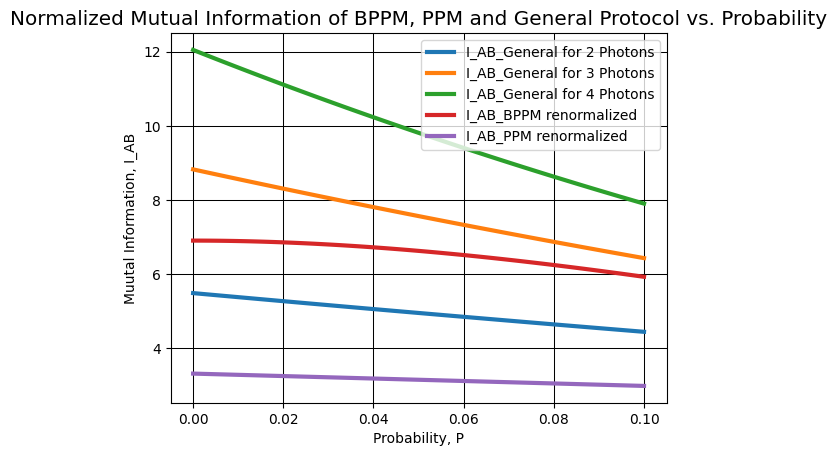

In [ ]:

plt.plot(P_list, I_AB_General_n2_list, linewidth=3, label='I_AB_General for 2 Photons')
# Plot for n_General = 3
plt.plot(P_list, I_AB_General_n3_list, linewidth=3, label='I_AB_General for 3 Photons')

plt.plot(P_list, I_AB_General_n4_list, linewidth=3, label='I_AB_General for 4 Photons')

plt.plot(P_list, I_AB_BPPM_list, label='I_AB_BPPM renormalized', linewidth=3, alpha=1)
plt.plot(P_list, I_AB_PPM_list, label='I_AB_PPM renormalized', linewidth=3, alpha=1)

# Add axis labels and a title
plt.xlabel('Probability, P')
plt.ylabel('Muutal Information, I_AB')
plt.title('Normalized Mutual Information of BPPM, PPM and General Protocol vs. Probability', fontsize='x-large')

plt.grid(color='k', linestyle='-', linewidth=0.75)

# Add a legend
plt.legend()

# Show the plot
plt.show()

# 6, 8, 1/8, 2/16, 3/24. 4/ 32

In [ ]:
I_AB_BPPM_list = []
I_AB_PPM_list = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
  n = 6
  N_n = compute_N(n) 
  P_D_val = P_D(n,P, 0,0,0) # P_D(n,P_l,P_a, l=0,a=0)
  
  P_AB_BPPM_val = P_AB_BPPM(n, P, P_D_val)
  P_AB_BPPM_val = np.array(P_AB_BPPM_val) # convert list of lists to numpy array
  P_AB_BPPM_val = np.where(P_AB_BPPM_val <= 0, 1e-15, P_AB_BPPM_val)

  H_A_BPPM_val = H_A_BPPM(P_AB_BPPM_val)
  H_B_BPPM_val = H_B_BPPM(P_AB_BPPM_val)
  H_AB_BPPM_val = H_AB_BPPM(P_AB_BPPM_val)
  I_AB_BPPM_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val)
  I_AB_BPPM_list.append(I_AB_BPPM_val)

  n_PPM = 1
  M = 8
  #N_n = compute_N(n) 

  P_D_PPM_val = P_D_PPM(n_PPM,P, 0, l=0,a=0)   

  P_AB_PPM_val = P_AB_PPM(M, P_D_PPM_val) # P_AB_PPM(n, P)
  P_AB_PPM_val = np.array(P_AB_PPM_val) # convert list of lists to numpy array
  P_AB_PPM_val = np.where(P_AB_PPM_val <= 0, 1e-9, P_AB_PPM_val)

  H_A_PPM_val = H_A_PPM(P_AB_PPM_val)
  H_B_PPM_val = H_B_PPM(P_AB_PPM_val)
  H_AB_PPM_val = H_AB_PPM(P_AB_PPM_val)

  I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)
  I_AB_PPM_list.append(I_AB_PPM_val)


In [ ]:
I_AB_General_n2_list = []
I_AB_General_n3_list = []
I_AB_General_n4_list = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
  M = 5
  compute_M(M)
# n_General = 2
  n_General = 2
  T_General = compute_T_General(n_General, M)

  P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

  P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
  P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
  P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

  H_A_General_val = H_A_General(P_AB_General_val)
  H_B_General_val = H_B_General(P_AB_General_val)
  H_AB_General_val = H_AB_General(P_AB_General_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
  I_AB_General_n2_list.append(I_AB_General_val)

  # n_General = 3
  n_General = 3
  T_General = compute_T_General(n_General, M)

  P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

  P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
  P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
  P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

  H_A_General_val = H_A_General(P_AB_General_val)
  H_B_General_val = H_B_General(P_AB_General_val)
  H_AB_General_val = H_AB_General(P_AB_General_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
  I_AB_General_n3_list.append(I_AB_General_val)

    # n_General = 3
  n_General = 4
  T_General = compute_T_General(n_General, M)

  P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

  P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
  P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
  P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

  H_A_General_val = H_A_General(P_AB_General_val)
  H_B_General_val = H_B_General(P_AB_General_val)
  H_AB_General_val = H_AB_General(P_AB_General_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
  I_AB_General_n4_list.append(I_AB_General_val)

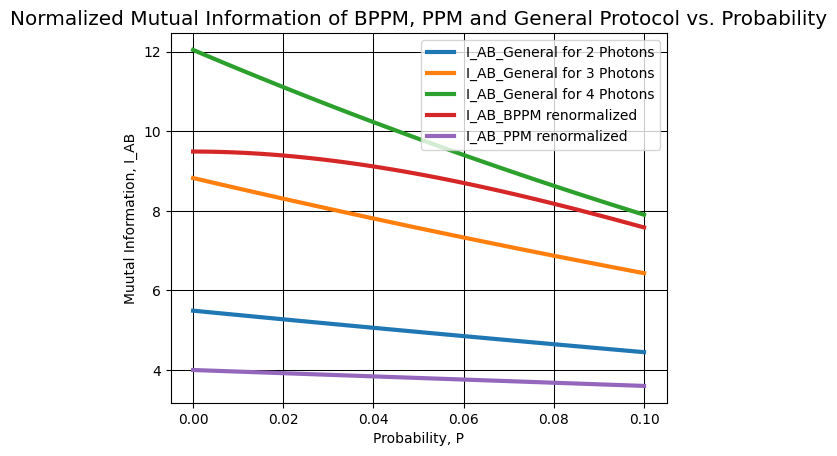

In [11]:

plt.plot(P_list, I_AB_General_n2_list, linewidth=3, label='I_AB_General for 2 Photons')
# Plot for n_General = 3
plt.plot(P_list, I_AB_General_n3_list, linewidth=3, label='I_AB_General for 3 Photons')

plt.plot(P_list, I_AB_General_n4_list, linewidth=3, label='I_AB_General for 4 Photons')

plt.plot(P_list, I_AB_BPPM_list, label='I_AB_BPPM renormalized', linewidth=3, alpha=1)
plt.plot(P_list, I_AB_PPM_list, label='I_AB_PPM renormalized', linewidth=3, alpha=1)

# Add axis labels and a title
plt.xlabel('Probability, P')
plt.ylabel('Muutal Information, I_AB')
plt.title('Normalized Mutual Information of BPPM, PPM and General Protocol vs. Probability', fontsize='x-large')

plt.grid(color='k', linestyle='-', linewidth=0.75)

# Add a legend
plt.legend()

# Show the plot
plt.show()

7, 11, 

In [48]:
I_AB_BPPM_list = []
I_AB_PPM_list = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
  n = 7
  N_n = compute_N(n) 
  P_D_val = P_D(n,P, 0,0,0) # P_D(n,P_l,P_a, l=0,a=0)
  
  P_AB_BPPM_val = P_AB_BPPM(n, P, P_D_val)
  P_AB_BPPM_val = np.array(P_AB_BPPM_val) # convert list of lists to numpy array
  P_AB_BPPM_val = np.where(P_AB_BPPM_val <= 0, 1e-15, P_AB_BPPM_val)

  H_A_BPPM_val = H_A_BPPM(P_AB_BPPM_val)
  H_B_BPPM_val = H_B_BPPM(P_AB_BPPM_val)
  H_AB_BPPM_val = H_AB_BPPM(P_AB_BPPM_val)
  I_AB_BPPM_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val)
  I_AB_BPPM_list.append(I_AB_BPPM_val)

  n_PPM = 1
  M = 11
  #N_n = compute_N(n) 

  P_D_PPM_val = P_D_PPM(n_PPM,P, 0, l=0,a=0)   

  P_AB_PPM_val = P_AB_PPM(M, P_D_PPM_val) # P_AB_PPM(n, P)
  P_AB_PPM_val = np.array(P_AB_PPM_val) # convert list of lists to numpy array
  P_AB_PPM_val = np.where(P_AB_PPM_val <= 0, 1e-9, P_AB_PPM_val)

  H_A_PPM_val = H_A_PPM(P_AB_PPM_val)
  H_B_PPM_val = H_B_PPM(P_AB_PPM_val)
  H_AB_PPM_val = H_AB_PPM(P_AB_PPM_val)

  I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)
  I_AB_PPM_list.append(I_AB_PPM_val)


In [49]:
I_AB_General_n2_list = []
I_AB_General_n3_list = []
I_AB_General_n4_list = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
  M = 11
  compute_M(M)
# n_General = 2
  n_General = 2
  T_General = compute_T_General(n_General, M)

  P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

  P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
  P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
  P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

  H_A_General_val = H_A_General(P_AB_General_val)
  H_B_General_val = H_B_General(P_AB_General_val)
  H_AB_General_val = H_AB_General(P_AB_General_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
  I_AB_General_n2_list.append(I_AB_General_val)

  # n_General = 3
  n_General = 3
  T_General = compute_T_General(n_General, M)

  P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

  P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
  P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
  P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

  H_A_General_val = H_A_General(P_AB_General_val)
  H_B_General_val = H_B_General(P_AB_General_val)
  H_AB_General_val = H_AB_General(P_AB_General_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
  I_AB_General_n3_list.append(I_AB_General_val)

    # n_General = 4
  n_General = 4
  T_General = compute_T_General(n_General, M)

  P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

  P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
  P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
  P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

  H_A_General_val = H_A_General(P_AB_General_val)
  H_B_General_val = H_B_General(P_AB_General_val)
  H_AB_General_val = H_AB_General(P_AB_General_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
  I_AB_General_n4_list.append(I_AB_General_val)

: 

: 

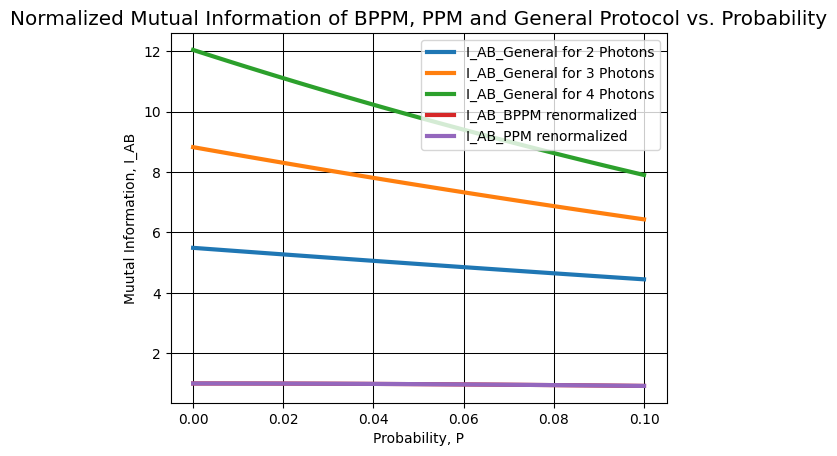

In [ ]:
plt.plot(P_list, I_AB_General_n2_list, linewidth=3, label='I_AB_General for 2 Photons')
# Plot for n_General = 3
plt.plot(P_list, I_AB_General_n3_list, linewidth=3, label='I_AB_General for 3 Photons')

plt.plot(P_list, I_AB_General_n4_list, linewidth=3, label='I_AB_General for 4 Photons')

plt.plot(P_list, I_AB_BPPM_list, label='I_AB_BPPM renormalized', linewidth=3, alpha=1)
plt.plot(P_list, I_AB_PPM_list, label='I_AB_PPM renormalized', linewidth=3, alpha=1)

# Add axis labels and a title
plt.xlabel('Probability, P')
plt.ylabel('Muutal Information, I_AB')
plt.title('Normalized Mutual Information of BPPM, PPM and General Protocol vs. Probability', fontsize='x-large')

plt.grid(color='k', linestyle='-', linewidth=0.75)

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Normailized 

In [41]:
I_AB_BPPM_list = []
I_AB_PPM_list = []

P_list = np.linspace(1e-15,0.1,101)

for P in P_list:
  n = 5
  N_n = compute_N(n) 
  P_D_val = P_D(n,P, 0,0,0) # P_D(n,P_l,P_a, l=0,a=0)
  
  P_AB_BPPM_val = P_AB_BPPM(n, P, P_D_val)
  P_AB_BPPM_val = np.array(P_AB_BPPM_val) # convert list of lists to numpy array
  P_AB_BPPM_val = np.where(P_AB_BPPM_val <= 0, 1e-15, P_AB_BPPM_val)

  H_A_BPPM_val = H_A_BPPM(P_AB_BPPM_val)
  H_B_BPPM_val = H_B_BPPM(P_AB_BPPM_val)
  H_AB_BPPM_val = H_AB_BPPM(P_AB_BPPM_val)
  I_AB_BPPM_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val)

  I_AB_BPPM_normalized_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val) / I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, 0)
  I_AB_BPPM_list.append(I_AB_BPPM_normalized_val)

  n_PPM = 1
  M = 5
  #N_n = compute_N(n) 

  P_D_PPM_val = P_D_PPM(n_PPM,P, 0, l=0,a=0)   

  P_AB_PPM_val = P_AB_PPM(M, P_D_PPM_val) # P_AB_PPM(n, P)
  P_AB_PPM_val = np.array(P_AB_PPM_val) # convert list of lists to numpy array
  P_AB_PPM_val = np.where(P_AB_PPM_val <= 0, 1e-9, P_AB_PPM_val)

  H_A_PPM_val = H_A_PPM(P_AB_PPM_val)
  H_B_PPM_val = H_B_PPM(P_AB_PPM_val)
  H_AB_PPM_val = H_AB_PPM(P_AB_PPM_val)

  I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)
  
  I_AB_PPM_normalized_val =  I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_val) / I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, 0)
  # I_AB_PPM_list.append(I_AB_PPM_val)
  I_AB_PPM_list.append(I_AB_PPM_normalized_val)





In [42]:
I_AB_General_n2_list = []
I_AB_General_n3_list = []
I_AB_General_n4_list = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
  M = 5
  compute_M(M)
# n_General = 2
  n_General = 2
  T_General = compute_T_General(n_General, M)

  P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

  P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
  P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
  P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

  H_A_General_val = H_A_General(P_AB_General_val)
  H_B_General_val = H_B_General(P_AB_General_val)
  H_AB_General_val = H_AB_General(P_AB_General_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
  I_AB_General_normalized_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val) / I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, 0)

  I_AB_General_n2_list.append(I_AB_General_normalized_val)

  # n_General = 3
  n_General = 3
  T_General = compute_T_General(n_General, M)

  P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

  P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
  P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
  P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

  H_A_General_val = H_A_General(P_AB_General_val)
  H_B_General_val = H_B_General(P_AB_General_val)
  H_AB_General_val = H_AB_General(P_AB_General_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
  I_AB_General_normalized_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val) / I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, 0)

  I_AB_General_n3_list.append(I_AB_General_normalized_val)


  #   # n_General = 4
  # n_General = 4
  # T_General = compute_T_General(n_General, M)

  # P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

  # P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
  # P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
  # P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

  # H_A_General_val = H_A_General(P_AB_General_val)
  # H_B_General_val = H_B_General(P_AB_General_val)
  # H_AB_General_val = H_AB_General(P_AB_General_val)

  # I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
  # I_AB_General_normalized_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val) / I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, 0)

  # I_AB_General_n4_list.append(I_AB_General_normalized_val)

  

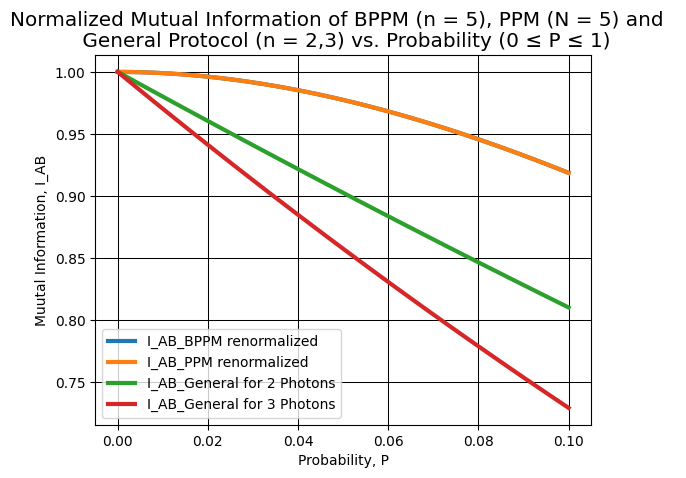

In [43]:
plt.plot(P_list, I_AB_BPPM_list, label='I_AB_BPPM renormalized', linewidth=3, alpha=1)
plt.plot(P_list, I_AB_PPM_list, label='I_AB_PPM renormalized', linewidth=3, alpha=1)

plt.plot(P_list, I_AB_General_n2_list, linewidth=3, label='I_AB_General for 2 Photons')
# Plot for n_General = 3
plt.plot(P_list, I_AB_General_n3_list, linewidth=3, label='I_AB_General for 3 Photons')

# plt.plot(P_list, I_AB_General_n4_list, linewidth=3, label='I_AB_General for 4 Photons')


# Add axis labels and a title
plt.xlabel('Probability, P')
plt.ylabel('Muutal Information, I_AB')
plt.title('Normalized Mutual Information of BPPM (n = 5), PPM (N = 5) and  \n General Protocol (n = 2,3) vs. Probability (0 \u2264 P \u2264 1)', fontsize='x-large')

plt.grid(color='k', linestyle='-', linewidth=0.75)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [37]:
I_AB_BPPM_list = []
I_AB_PPM_list = []

P_list = np.linspace(1e-15,0.1,101)

for P in P_list:
  n = 7
  N_n = compute_N(n) 
  P_D_val = P_D(n,P, 0,0,0) # P_D(n,P_l,P_a, l=0,a=0)
  
  P_AB_BPPM_val = P_AB_BPPM(n, P, P_D_val)
  P_AB_BPPM_val = np.array(P_AB_BPPM_val) # convert list of lists to numpy array
  P_AB_BPPM_val = np.where(P_AB_BPPM_val <= 0, 1e-15, P_AB_BPPM_val)

  H_A_BPPM_val = H_A_BPPM(P_AB_BPPM_val)
  H_B_BPPM_val = H_B_BPPM(P_AB_BPPM_val)
  H_AB_BPPM_val = H_AB_BPPM(P_AB_BPPM_val)
  I_AB_BPPM_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val)

  I_AB_BPPM_normalized_val = I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, P_D_val) / I_AB_BPPM(H_A_BPPM_val, H_B_BPPM_val, H_AB_BPPM_val, 0)
  I_AB_BPPM_list.append(I_AB_BPPM_normalized_val)

  n_PPM = 1
  M = 11
  #N_n = compute_N(n) 

  P_D_PPM_val = P_D_PPM(n_PPM,P, 0, l=0,a=0)   

  P_AB_PPM_val = P_AB_PPM(M, P_D_PPM_val) # P_AB_PPM(n, P)
  P_AB_PPM_val = np.array(P_AB_PPM_val) # convert list of lists to numpy array
  P_AB_PPM_val = np.where(P_AB_PPM_val <= 0, 1e-9, P_AB_PPM_val)

  H_A_PPM_val = H_A_PPM(P_AB_PPM_val)
  H_B_PPM_val = H_B_PPM(P_AB_PPM_val)
  H_AB_PPM_val = H_AB_PPM(P_AB_PPM_val)

  I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)
  
  I_AB_PPM_normalized_val =  I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_val) / I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, 0)
  # I_AB_PPM_list.append(I_AB_PPM_val)
  I_AB_PPM_list.append(I_AB_PPM_normalized_val)

In [44]:
I_AB_General_n2_list = []
I_AB_General_n3_list = []
I_AB_General_n4_list = []

P_list = np.linspace(1e-6,0.1,101)

for P in P_list:
  M = 11
  compute_M(M)
# n_General = 2
  n_General = 2
  T_General = compute_T_General(n_General, M)

  P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

  P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
  P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
  P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

  H_A_General_val = H_A_General(P_AB_General_val)
  H_B_General_val = H_B_General(P_AB_General_val)
  H_AB_General_val = H_AB_General(P_AB_General_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
  I_AB_General_normalized_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val) / I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, 0)

  I_AB_General_n2_list.append(I_AB_General_normalized_val)

  # n_General = 3
  n_General = 3
  T_General = compute_T_General(n_General, M)

  P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

  P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
  P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
  P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

  H_A_General_val = H_A_General(P_AB_General_val)
  H_B_General_val = H_B_General(P_AB_General_val)
  H_AB_General_val = H_AB_General(P_AB_General_val)

  I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
  I_AB_General_normalized_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val) / I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, 0)

  I_AB_General_n3_list.append(I_AB_General_normalized_val)


  #   # n_General = 4
  # n_General = 4
  # T_General = compute_T_General(n_General, M)

  # P_D_General_val = P_D_General(n_General,P, 0, l=0,a=0)   

  # P_AB_General_val = P_AB_General(n_General) # P_AB_OOK(n, P)
  # P_AB_General_val = np.array(P_AB_General_val) # convert list of lists to numpy array
  # P_AB_General_val = np.where(P_AB_General_val <= 0, 1e-9, P_AB_General_val)

  # H_A_General_val = H_A_General(P_AB_General_val)
  # H_B_General_val = H_B_General(P_AB_General_val)
  # H_AB_General_val = H_AB_General(P_AB_General_val)

  # I_AB_General_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val)
  # I_AB_General_normalized_val = I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, P_D_General_val) / I_AB_General(H_A_General_val, H_B_General_val, H_AB_General_val, 0)

  # I_AB_General_n4_list.append(I_AB_General_normalized_val)

  

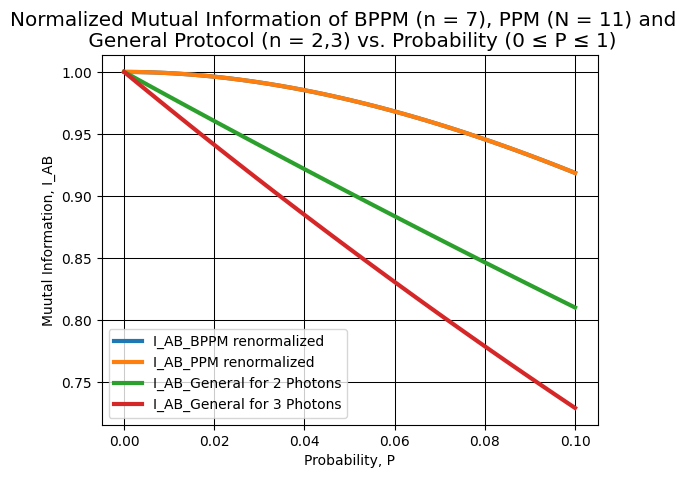

In [45]:
plt.plot(P_list, I_AB_BPPM_list, label='I_AB_BPPM renormalized', linewidth=3, alpha=1)
plt.plot(P_list, I_AB_PPM_list, label='I_AB_PPM renormalized', linewidth=3, alpha=1)

plt.plot(P_list, I_AB_General_n2_list, linewidth=3, label='I_AB_General for 2 Photons')
# # Plot for n_General = 3
plt.plot(P_list, I_AB_General_n3_list, linewidth=3, label='I_AB_General for 3 Photons')


# Add axis labels and a title
plt.xlabel('Probability, P')
plt.ylabel('Muutal Information, I_AB')
plt.title('Normalized Mutual Information of BPPM (n = 7), PPM (N = 11) and  \n General Protocol (n = 2,3) vs. Probability (0 \u2264 P \u2264 1)', fontsize='x-large')

plt.grid(color='k', linestyle='-', linewidth=0.75)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
I_AB_PPM(0,0,0,0)

0

In [ ]:
P_D(n,0, 0,0,0)

0.0

In [ ]:
I_AB_BPPM(0,0,0,0)

0

In [ ]:
I_AB_BPPM(H_A_BPPM(P_AB_BPPM(n, 0, P_D(n,0, 0,0,0))), H_B_BPPM(P_AB_BPPM(n, 0, P_D(n,0, 0,0,0))), H_AB_BPPM(P_AB_BPPM(n, 0, P_D(n,0, 0,0,0))), 0)

6.906463661409756

In [ ]:
H_A_BPPM(P_AB_BPPM(n, P, P_D(n,0, 0,0,0)))


6.906890595608516

ValueError: x and y must have same first dimension, but have shapes (101,) and (202,)

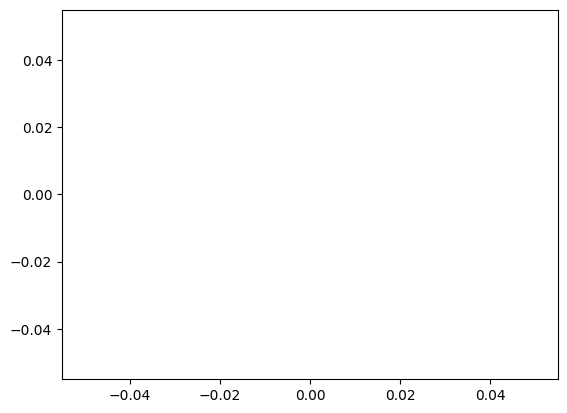